# Barcelona Housing Price Prediction — Modeling Story
This notebook tells the **data science story** behind the model selection:
**Dummy → Linear Regression → Decision Tree → Random Forest (10 vars) → Random Forest (5 vars + log(y))**.

> The production pipeline (training, reports, artifacts) lives in `scripts/` and `src/`.
This notebook focuses on **why** decisions were made.


## 0) Context & Goal

**Who is this for?** A portfolio-style project aimed at both technical and non-technical readers.

**Goal:** predict housing prices in Barcelona and compare **model complexity vs. performance**, while identifying the **main price drivers**.

**How to interpret error:** RMSE / MAE are reported in **euros (€)**, so they can be read as a *typical deviation from the true price* on the test split.


## 1) Setup

### ⚡ Quick start: Ensure reports are generated

If you're running this notebook for the first time and reports/ outputs are missing, run this in a terminal:

```bash
# From the project root, run:
python scripts/train.py --cv
```

This generates:
- `reports/metrics.json` — full experiment metadata
- `reports/cv_summary.csv` — 5-fold CV results on TRAIN split
- `reports/model_comparison.csv` — holdout test split results
- `reports/figures/*.png` — visualizations

The notebook will auto-detect and load these files in the next cell.

In [148]:
from pathlib import Path
import json

# Define required report paths
PROJECT_ROOT = Path("..").resolve()
REPORTS_DIR = PROJECT_ROOT / "reports"

REQUIRED_FILES = {
    "metrics.json": REPORTS_DIR / "metrics.json",
    "cv_summary.csv": REPORTS_DIR / "cv_summary.csv",
    "model_comparison.csv": REPORTS_DIR / "model_comparison.csv",
}

# Check if all required files exist
missing_files = [name for name, path in REQUIRED_FILES.items() if not path.exists()]

if missing_files:
    msg = f"""
## ⚠️ Missing reports

This notebook requires outputs from `scripts/train.py --cv`. 

**Missing:** {", ".join(missing_files)}

**To generate all reports, run from project root:**

```bash
python scripts/train.py --cv
```

Then re-run this notebook.
"""
    display(Markdown(msg))
    raise RuntimeError(f"Missing report files: {missing_files}. Run 'python scripts/train.py --cv' first.")

# If we reach here, all files exist. Load them.
print("✅ All required reports found. Loading...")

# Load metrics.json
with open(REQUIRED_FILES["metrics.json"], "r", encoding="utf-8") as f:
    metrics_payload = json.load(f)

# Load CSV files
import pandas as pd
cv_df = pd.read_csv(REQUIRED_FILES["cv_summary.csv"])
holdout_df = pd.read_csv(REQUIRED_FILES["model_comparison.csv"])

print(f"✅ Loaded {len(cv_df)} CV results")
print(f"✅ Loaded {len(holdout_df)} holdout test results")

✅ All required reports found. Loading...
✅ Loaded 5 CV results
✅ Loaded 5 holdout test results


This notebook is meant to be **read top‑to‑bottom** and should run with **Run All**.

For a fully reproducible run that saves artifacts (metrics, model, plots), use:
```bash
python scripts/train.py --data data/raw/Barcelona_2018.csv --reports-dir reports --artifacts-dir artifacts
```


In [ ]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


# Project paths (this notebook assumes it's located in: notebooks/)
PROJECT_ROOT = Path("..").resolve()
SRC_PATH = PROJECT_ROOT / "src"
NB_UTILS_PATH = PROJECT_ROOT / "notebooks" / "utils"   
DATA_PATH = PROJECT_ROOT / "data" / "raw" / "Barcelona_2018.csv"

# Ensure local imports work (src/ + notebooks/utils)
for p in (SRC_PATH, NB_UTILS_PATH):
    p_str = str(p)
    if p_str not in sys.path:
        sys.path.insert(0, p_str)

# Toggle: save a couple of notebook figures (optional)
SAVE_FIGS = False
FIG_DIR = PROJECT_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def nb_save(fig, filename: str, dpi: int = 300) -> None:
    """Save notebook figures safely (avoids MemoryError on tight renders)."""
    if not SAVE_FIGS:
        return
    out_path = FIG_DIR / filename
    try:
        # Uses the same defensive saver as the scripts
        from bcn_housing.plots import _safe_savefig  # internal helper
        _safe_savefig(fig, out_path, dpi=dpi, tight=True, pad_inches=0.1)
    except Exception:
        out_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(out_path, dpi=dpi, bbox_inches="tight")

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_PATH:", SRC_PATH)
print("NB_UTILS_PATH:", NB_UTILS_PATH)
print("DATA_PATH:", DATA_PATH)
print("DATA_PATH exists:", DATA_PATH.exists())


PROJECT_ROOT: C:\Users\54911\OneDrive\Desktop\barcelona_housing_ml
SRC_PATH: C:\Users\54911\OneDrive\Desktop\barcelona_housing_ml\src
NB_UTILS_PATH: C:\Users\54911\OneDrive\Desktop\barcelona_housing_ml\notebooks\utils
DATA_PATH: C:\Users\54911\OneDrive\Desktop\barcelona_housing_ml\data\raw\Barcelona_2018.csv
DATA_PATH exists: True


## 2) Load data + quick checks

We load the raw CSV and run quick sanity checks (shape, duplicates, missing target, min/max price).  
The full data‑prep used by the scripts lives in `bcn_housing.data`.


In [ ]:
from bcn_housing.data import load_csv, basic_checks
from bcn_housing.config import TARGET


from bcn_housing.plots import (
    save_feature_importance,
    save_metric_evolution,
    save_residuals_hist_log,
    save_ytrue_vs_ypred
)
from band_eval_utils import (
    price_band_error_analysis,
    plot_band_summary,
    plot_abs_error_boxplot
)

from plots_eda import (
    plot_target_distribution,
    plot_topk_abs_corr_with_target,
    plot_price_vs_constructed_area
)
from model_tradeoff import plot_cv_tradeoff, build_model_selection_markdown

from model_summary_md import build_model_summary_markdown


df = load_csv(str(DATA_PATH))
print("Shape:", df.shape)
basic_checks(df, TARGET)
df.head()


Shape: (61486, 46)


,ASSETID,PERIOD,PRICE,UNITPRICE,ADTYPOLOGYID,ADOPERATIONID,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,...,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_DIAGONAL,LONGITUDE,LATITUDE,CITYNAME,ADTYPOLOGY,ADOPERATION
0,A11898131848556022319,201803,323000,3845.238095,HOME,SALE,84,4,1,1,...,0,1,1.876290,0.354004,1.475264,2.149566,41.380027,Barcelona,HOME,SALE
1,A18099432772155664747,201803,217000,2583.333333,HOME,SALE,84,3,2,0,...,0,1,2.118595,0.284372,1.194261,2.145689,41.381632,Barcelona,HOME,SALE
2,A2003099089407882787,201803,114000,1407.407407,HOME,SALE,81,2,1,0,...,1,0,4.127099,0.261574,2.504982,2.173891,41.423929,Barcelona,HOME,SALE
3,A1010373782315301134,201803,378000,4784.810127,HOME,SALE,79,2,1,0,...,0,1,2.238113,0.158527,0.795605,2.143379,41.384923,Barcelona,HOME,SALE
4,A12978912200216838006,201803,434000,3909.909910,HOME,SALE,111,4,2,1,...,0,1,2.333066,0.101568,1.200265,2.143230,41.381076,Barcelona,HOME,SALE


## 3) Minimal EDA (only what supports modeling)

**Why this section?** We keep EDA minimal—only what we need to motivate modeling choices:
- the target is **right‑skewed** → motivates **log(PRICE)** later
- area and location proxies are strong drivers → motivates the curated feature set
- relationships are not purely linear → motivates tree‑based models


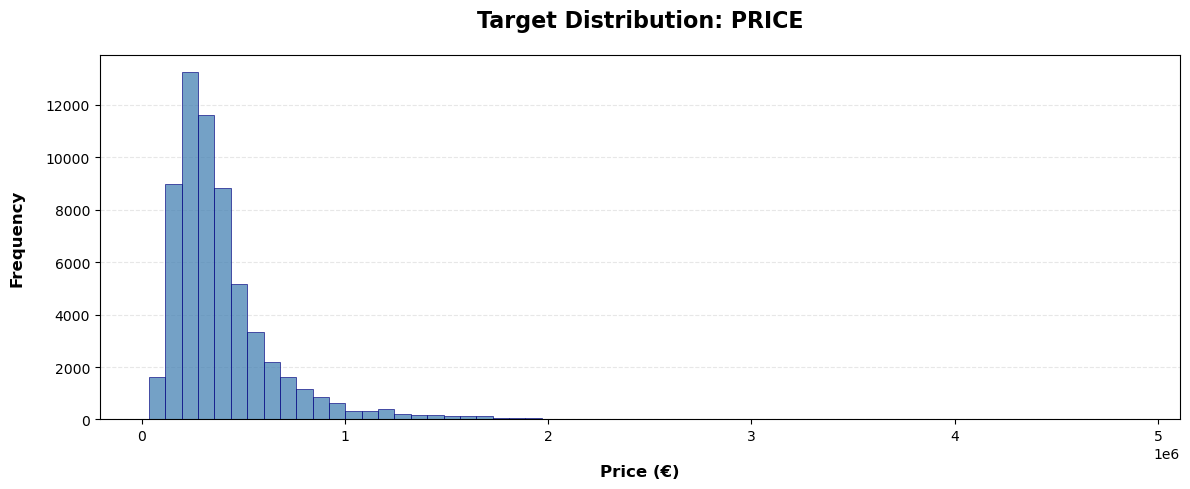

In [151]:
plot_target_distribution(df, TARGET, save_figs=SAVE_FIGS, nb_save=nb_save);


**So what?** `PRICE` is strongly **right‑skewed** (long high‑price tail).  
This makes RMSE sensitive to expensive outliers and motivates using a **log transform** (`log1p(PRICE)`) for the final model.


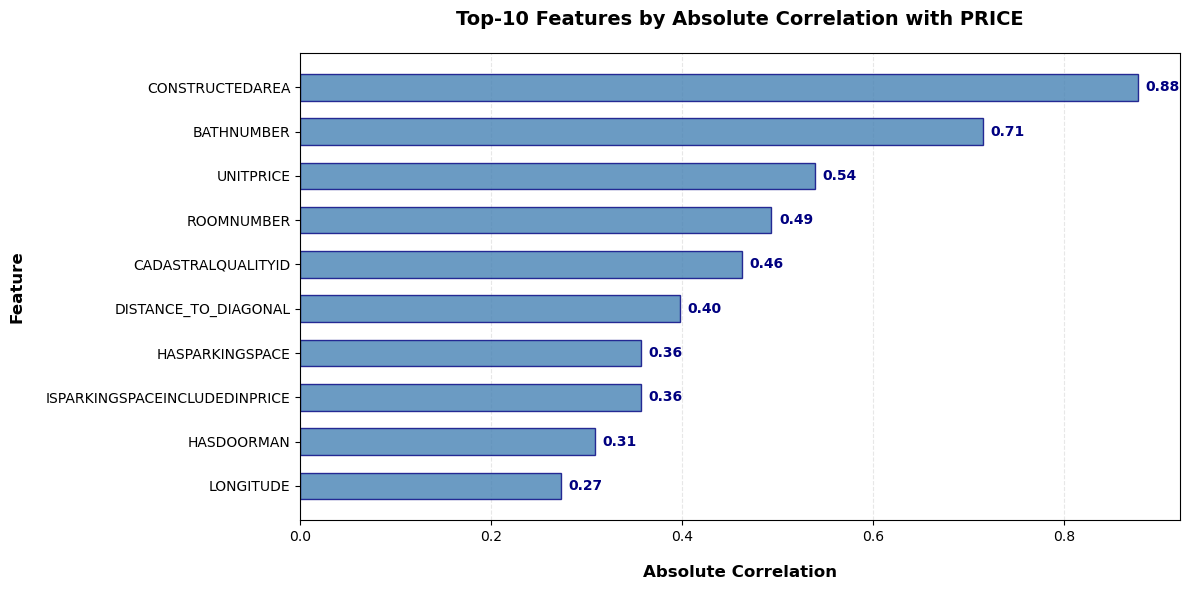

In [152]:
plot_topk_abs_corr_with_target(df, TARGET, topk=10, save_figs=SAVE_FIGS, nb_save=nb_save);


**So what?** `CONSTRUCTEDAREA` stands out as the strongest single driver, and **location proxies** (lat/lon + distance features) also matter.  
This motivates including both **size** and **location** features in the model ladder.


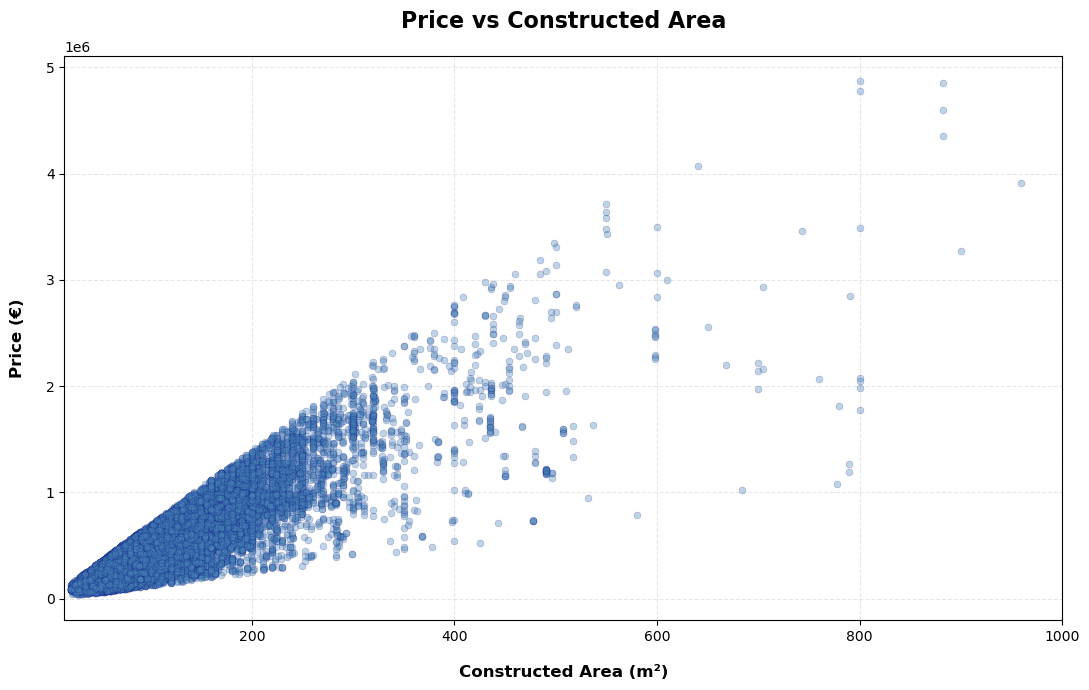

In [153]:
plot_price_vs_constructed_area(df, TARGET, save_figs=SAVE_FIGS, nb_save=nb_save);


**So what?** The relationship between price and area is monotonic but **not perfectly linear**, with increasing variance at larger areas (heteroskedasticity) and outliers.  
Tree ensembles (RF) can capture these non‑linear patterns better than a simple linear model.


## 4) Prepare a single split (fair comparison across models)

To compare models fairly, we:
- build a **single train/test split** (same indices for every model)
- use a **shared base dataset** (rows with complete data for the union of candidate features)

This avoids a common pitfall: comparing models trained on **different subsets** of the data.


In [154]:
from bcn_housing.config import (
    SEED, TEST_SIZE, MODEL_LABELS, MODEL_ORDER,
    FEATURES_LR_BENCH, FEATURES_TREE_2, FEATURES_RF10, FEATURES_RF5
)

# Use a common base dataset so all models see the same rows and the same split
ALL_FEATURES = sorted(set(FEATURES_LR_BENCH + FEATURES_TREE_2 + FEATURES_RF10 + FEATURES_RF5))
base = df[ALL_FEATURES + [TARGET]].dropna().copy()
print("Base rows used (after dropna on union features):", base.shape[0])

from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(base.index, test_size=TEST_SIZE, random_state=SEED)

def split_xy(features):
    X_train = base.loc[train_idx, features]
    y_train = base.loc[train_idx, TARGET]
    X_test  = base.loc[test_idx, features]
    y_test  = base.loc[test_idx, TARGET]
    return X_train, X_test, y_train, y_test


Base rows used (after dropna on union features): 61486


## 5) Baselines and model ladder

We follow a simple “model ladder”:
1) **Dummy baseline** (median) — sanity check  
2) **Linear Regression** on area — interpretable benchmark  
3) **Shallow Decision Tree** (2 features) — captures simple non‑linearities  
4) **Random Forest (10 features)** — stronger non‑linear model  
5) **Random Forest (5 features) + log(y)** — final trade‑off (simpler + robust)

**Why only 10 features (and not “all columns”)?** This notebook uses a *curated* set:
- features with **clear meaning** (size + location proxies + simple amenities)
- typically **low missingness** and available at prediction time
- avoids high‑cardinality IDs / administrative fields that can add noise without proper encoding

A full feature‑engineering pass (encoding, interactions, richer spatial signals) is great “next work” — but outside the scope of this story.

The goal is not to squeeze every last point of performance, but to show **reasoned model selection**.



In [155]:
from bcn_housing.modeling import make_dummy, make_lr, make_tree, make_rf, with_log_target
from bcn_housing.evaluation import metrics

def run_model(name, model, features):
    X_train, X_test, y_train, y_test = split_xy(features)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    m = metrics(y_test, y_pred)
    row = {"Model": name, "n_features": len(features), **m}
    return row, (y_test, y_pred), model

candidates = [
    ("Benchmark Dummy (median)", make_dummy("median"), FEATURES_LR_BENCH),
    ("LR (area)", make_lr(), FEATURES_LR_BENCH),
    ("DecisionTree (2 vars, depth=2)", make_tree(SEED, max_depth=2), FEATURES_TREE_2),
    ("RandomForest (10 vars)", make_rf(SEED), FEATURES_RF10),
    ("RandomForest (5 vars) + log(y)", with_log_target(make_rf(SEED)), FEATURES_RF5),
]

rows = []
cache = {}

for name, model, feats in candidates:
    row, (y_test, y_pred), fitted = run_model(name, model, feats)
    rows.append(row)
    cache[name] = {"model": fitted, "features": feats, "y_test": y_test, "y_pred": y_pred}

results = pd.DataFrame(rows).sort_values("RMSE")
results


,Model,n_features,RMSE,MAE,R2
3,RandomForest (10 vars),10,78123.722863,44343.302438,0.927870
4,RandomForest (5 vars) + log(y),5,82805.372441,47838.186408,0.918967
1,LR (area),1,136250.910425,92747.064656,0.780605
2,"DecisionTree (2 vars, depth=2)",2,164244.916160,110684.415960,0.681191
0,Benchmark Dummy (median),1,300699.203757,174409.741421,-0.068592


## 6) Compare models (RMSE / R²)

We compare models on the **same test split** using:
- **RMSE (€)** and **MAE (€)**: typical error magnitude in euros  
- **R²**: variance explained (can be negative for a weak baseline)

We focus on the **shape of improvement** as complexity increases.


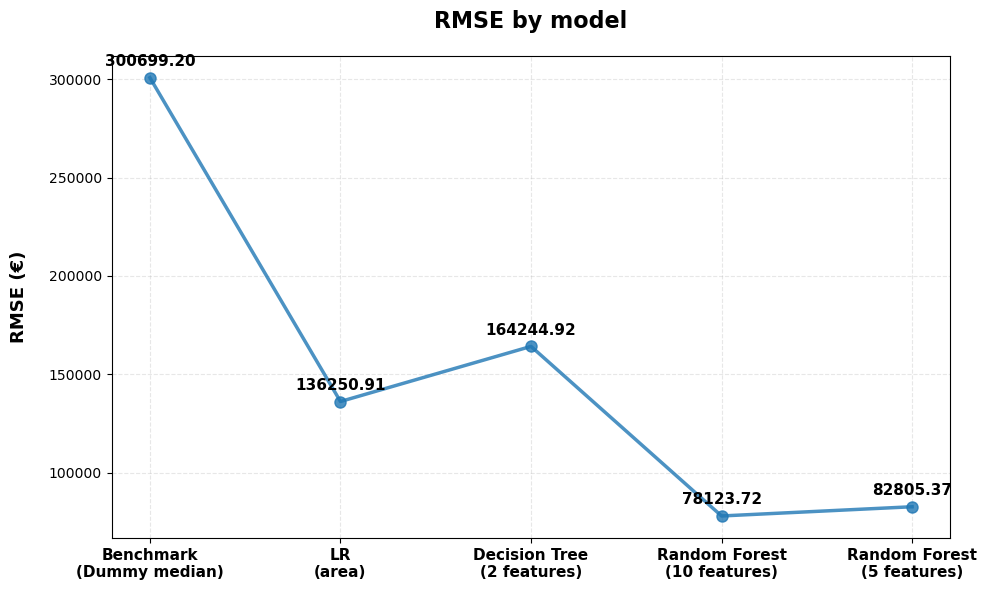

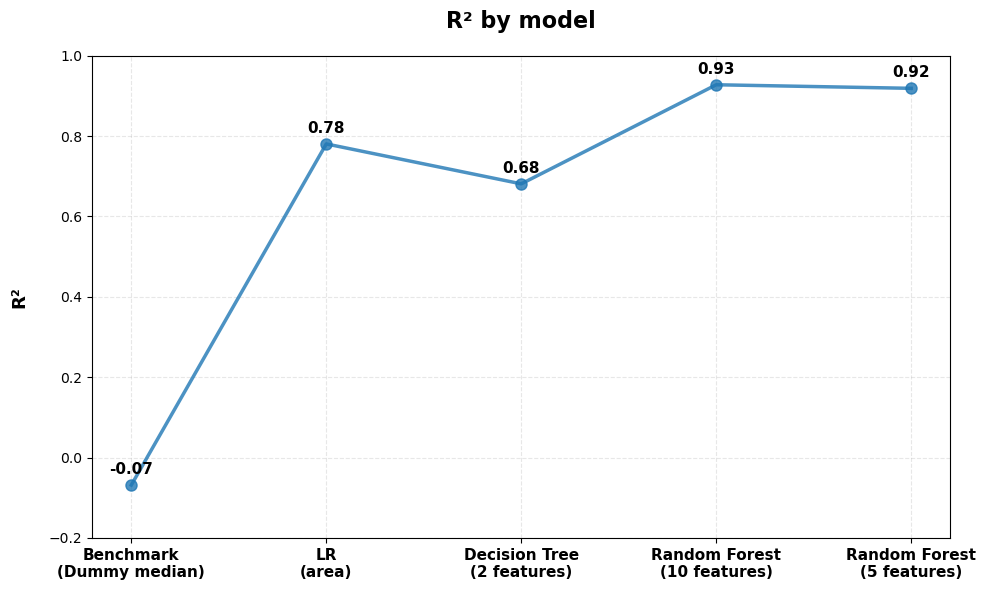

In [156]:
# RMSE (display only; no file output)
save_metric_evolution(
    results_df=results,
    model_order=MODEL_ORDER,
    model_labels=MODEL_LABELS,
    metric_col="RMSE",
    out_path=None,   # do not write to disk
    title="RMSE by model",
    ylabel="RMSE (€)",
    save=False,
    show=True,
    close=False,
)

# R² (display only; allow negatives for weak baselines such as the dummy model)
save_metric_evolution(
    results_df=results,
    model_order=MODEL_ORDER,
    model_labels=MODEL_LABELS,
    metric_col="R2",
    out_path=None,
    title="R² by model",
    ylabel="R²",
    ylim=(-0.2, 1),
    save=False,
    show=True,
    close=False,
)


## 6b) Robustness check: k-fold CV on TRAIN split

A single train/test split can be **lucky**. To validate robustness, we run **k-fold cross-validation (CV)** on the **TRAIN split only**:

- Split the TRAIN set into *k* folds
- For each fold: train on *k−1* folds, validate on the remaining fold
- Report **mean ± std** across folds

**So what?** Low std ⇒ stable performance across folds ⇒ less sensitivity to the particular split.


In [157]:
# CV summary (loaded from reports/cv_summary.csv)
from IPython.display import display, Markdown
import numpy as np

# Make sure we are sorted by RMSE_mean (best first)
cv_sorted = cv_df.sort_values("RMSE_mean", ascending=True).copy()

# Keep a compact, reader-friendly view
cv_view_cols = ["Model", "n_features", "RMSE_mean", "RMSE_std", "MAE_mean", "R2_mean"]
cv_view = cv_sorted[cv_view_cols].copy()

display(cv_view)

# --- Quick interpretation (best vs final) ---
final_name = metrics_payload.get("final_model_selected", "RandomForest (5 vars) + log(y)")
cv_folds = metrics_payload.get("cv", {}).get("folds", None)

best_cv = cv_sorted.iloc[0]
final_cv = cv_sorted[cv_sorted["Model"] == final_name].iloc[0] if (cv_sorted["Model"] == final_name).any() else None

def _std_pct(row, mean_col="RMSE_mean", std_col="RMSE_std"):
    return float(row[std_col]) / float(row[mean_col]) * 100.0

if final_cv is not None:
    delta_abs = float(final_cv["RMSE_mean"] - best_cv["RMSE_mean"])
    delta_pct = float(delta_abs / best_cv["RMSE_mean"] * 100.0)

    interpretation = f"""### So what?

- **Best CV performer:** **{best_cv['Model']}**  
  RMSE = €{best_cv['RMSE_mean']:,.0f} ± €{best_cv['RMSE_std']:,.0f}  (std = {_std_pct(best_cv):.2f}% of mean)

- **Final choice:** **{final_name}**  
  RMSE = €{final_cv['RMSE_mean']:,.0f} ± €{final_cv['RMSE_std']:,.0f}  (std = {_std_pct(final_cv):.2f}% of mean)

- **Trade-off (final vs best):** +€{delta_abs:,.0f} (**+{delta_pct:.2f}%**) mean RMSE, but fewer features and similar stability.

**Verdict:** CV confirms the ranking is not just split luck, and our final model remains **stable** across folds.
"""
else:
    interpretation = """### So what?

`final_model_selected` was not found inside `cv_summary.csv`.  
Check that the model name in `config.py` matches the `Model` column in CV results.
"""

# Add folds note (if available)
if cv_folds is not None:
    interpretation = f"**CV setup:** {int(cv_folds)}-fold on TRAIN split.\n\n" + interpretation

display(Markdown(interpretation))


,Model,n_features,RMSE_mean,RMSE_std,MAE_mean,R2_mean
0,RandomForest (10 vars),10,78720.496826,2365.130499,45634.299884,0.920366
1,RandomForest (5 vars) + log(y),5,84377.063420,1828.911916,49490.755812,0.908543
2,LR (area),1,134684.950504,2855.998413,91832.372245,0.766996
3,"DecisionTree (2 vars, depth=2)",2,157806.086955,1623.617677,109810.907478,0.680189
4,Benchmark Dummy (median),1,287784.467420,3328.143388,171624.977646,-0.062973


### So what?

- **Best CV performer:** **RandomForest (10 vars)**  
  RMSE = €78,720 ± €2,365  (std = 3.00% of mean)

- **Final choice:** **RandomForest (5 vars) + log(y)**  
  RMSE = €84,377 ± €1,829  (std = 2.17% of mean)

- **Trade-off (final vs best):** +€5,657 (**+7.19%**) mean RMSE, but fewer features and similar stability.

**Verdict:** CV confirms the ranking is not just split luck, and our final model remains **stable** across folds.


## 7) Feature importance (RF10) → justify selecting top-5

### Bridge: Trade-off → Feature Importance

The trade-off plot (above) shows RF(5+log) sacrifices **only +7.2% RMSE** for **5 fewer features**.

But **which 5 features actually matter?** The answer comes from analyzing RF(10)'s feature importance. 
If the top-5 variables concentrate most of the predictive power, we've found the right subset.

Let's check:


In [158]:
# Show the top-5 features that RF(5) uses
# Recalculate importance from RF(10) in case it wasn't loaded
rf10_name = "RandomForest (10 vars)"
if rf10_name in cache:
    rf10_model = cache[rf10_name]["model"]
    rf10_feats = cache[rf10_name]["features"]
    rf10_reg = getattr(rf10_model, "regressor_", rf10_model)
    imp_df = pd.DataFrame({
        "feature": rf10_feats,
        "importance": rf10_reg.feature_importances_
    }).sort_values("importance", ascending=False)
    
    top_5_features_list = list(imp_df['feature'].head(5))
    cumsum_importance = imp_df['importance'].head(5).sum()
    
    display(Markdown(f"""
### The key insight: Top-5 variables capture most predictive power

**Top-5 features from RF(10):**
1. {top_5_features_list[0]}
2. {top_5_features_list[1]}
3. {top_5_features_list[2]}
4. {top_5_features_list[3]}
5. {top_5_features_list[4]}

**These are exactly the features used by RF(5+log).**

**Cumulative importance:** {cumsum_importance:.1%} of total feature importance  
(The remaining 5 features in RF(10) contribute only {1 - cumsum_importance:.1%})

**Conclusion:** By dropping the bottom-5 features, we lose minimal predictive power 
while gaining simplicity, interpretability, and reduced overfitting risk.
"""))



### The key insight: Top-5 variables capture most predictive power

**Top-5 features from RF(10):**
1. CONSTRUCTEDAREA
2. LATITUDE
3. LONGITUDE
4. CADASTRALQUALITYID
5. DISTANCE_TO_CITY_CENTER

**These are exactly the features used by RF(5+log).**

**Cumulative importance:** 95.7% of total feature importance  
(The remaining 5 features in RF(10) contribute only 4.3%)

**Conclusion:** By dropping the bottom-5 features, we lose minimal predictive power 
while gaining simplicity, interpretability, and reduced overfitting risk.


We use the RF(10) model to estimate **feature importance** and justify reducing the feature set.

Idea: if most importance concentrates in a few variables, we can keep the story and the pipeline simpler by selecting a smaller subset (RF5) with minimal performance loss.


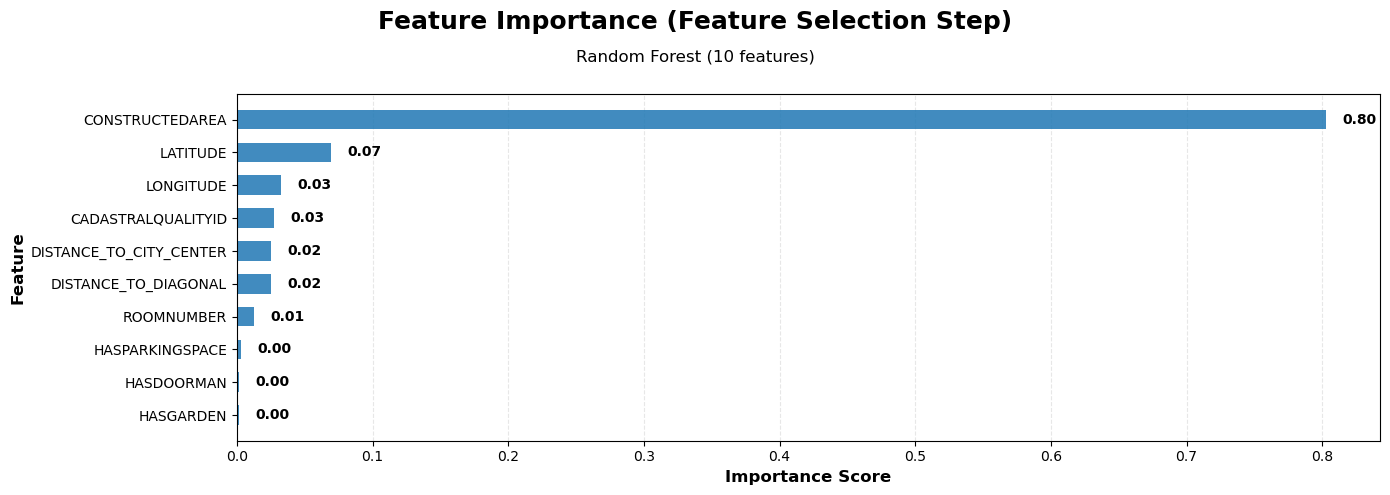

In [159]:
imp_df = save_feature_importance(
    model=cache["RandomForest (10 vars)"]["model"],
    feature_names=cache["RandomForest (10 vars)"]["features"],
    out_path=None,
    save=False, show=True, close=False,
    title="Feature Importance (Feature Selection Step)",
    subtitle="Random Forest (10 features)"
)


### Model selection trade-off (RF10 vs RF5)

RF(10) achieves the best performance, but we select **RF(5) + log(y)** as the final model to reduce feature dependency and keep the solution simpler to explain and maintain.

This reflects a common trade-off in applied ML: **interpretability/robustness vs. performance**, and **overfitting risk vs. generalization**.


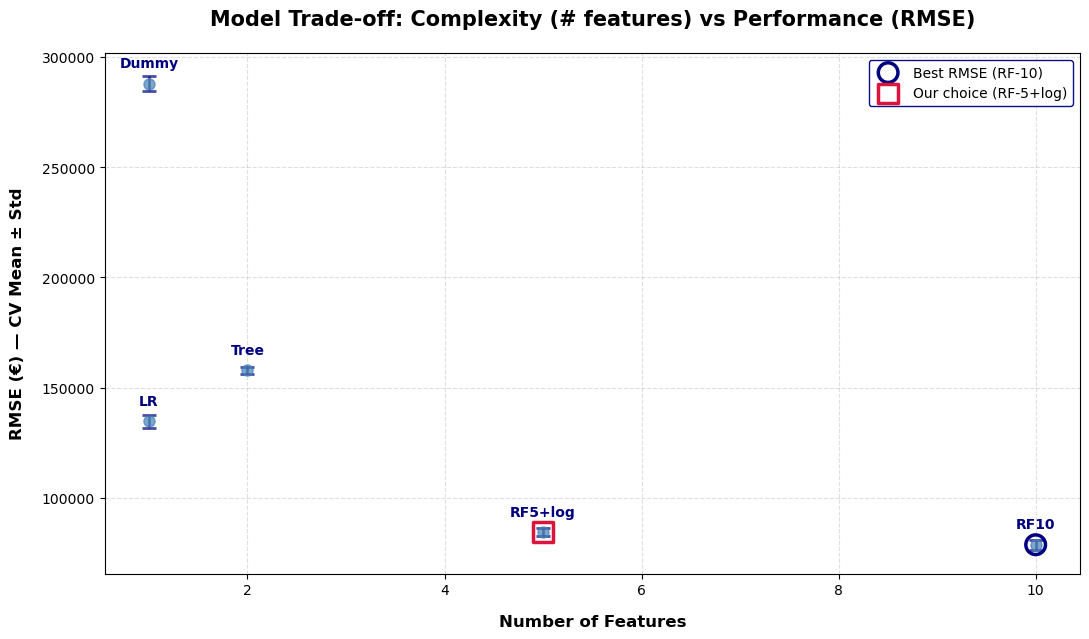

### Model Selection Justification

**Trade-off Analysis:**
- **RF(10)** achieves the best CV RMSE (€78,720), but requires **10 features**
- **RF(5+log)** trades **+€5,657 RMSE (+7.2%)** for **5 fewer features**
- **Result:** Simpler, more maintainable model with acceptable performance loss

**Why RF(5+log)?** Fewer features reduce overfitting risk and make the model easier to explain in production.


In [160]:
plot_cv_tradeoff(
    cv_sorted=cv_sorted,
    best_cv=best_cv,
    final_cv=final_cv,
    final_name=final_name,
    save_figs=SAVE_FIGS,
    nb_save=nb_save,
)

display(Markdown(build_model_selection_markdown(best_cv, final_cv)))


## 8) Final model diagnostics (RF5 + log(y))

Before “shipping” a model, we do lightweight diagnostics:
- **y_true vs y_pred**: check calibration and obvious bias
- **residuals (log space)**: check symmetry / heavy tails
- **Error analysis by price band (Holdout)**: check where the model test to fail more

This is not a full residual analysis, but enough to catch glaring issues.


### 8.1) y_true vs y_pred

The parity plot is a fast **calibration check**:

- Points close to the diagonal mean predictions are well aligned with the true prices.
- Systematic curvature or a “fan shape” often signals that error grows with price (heteroscedasticity).
- Large deviations at the top end usually indicate the model struggles with **rare / luxury listings**.

We do not expect perfection—this plot is mainly to catch *obvious bias* before moving forward.


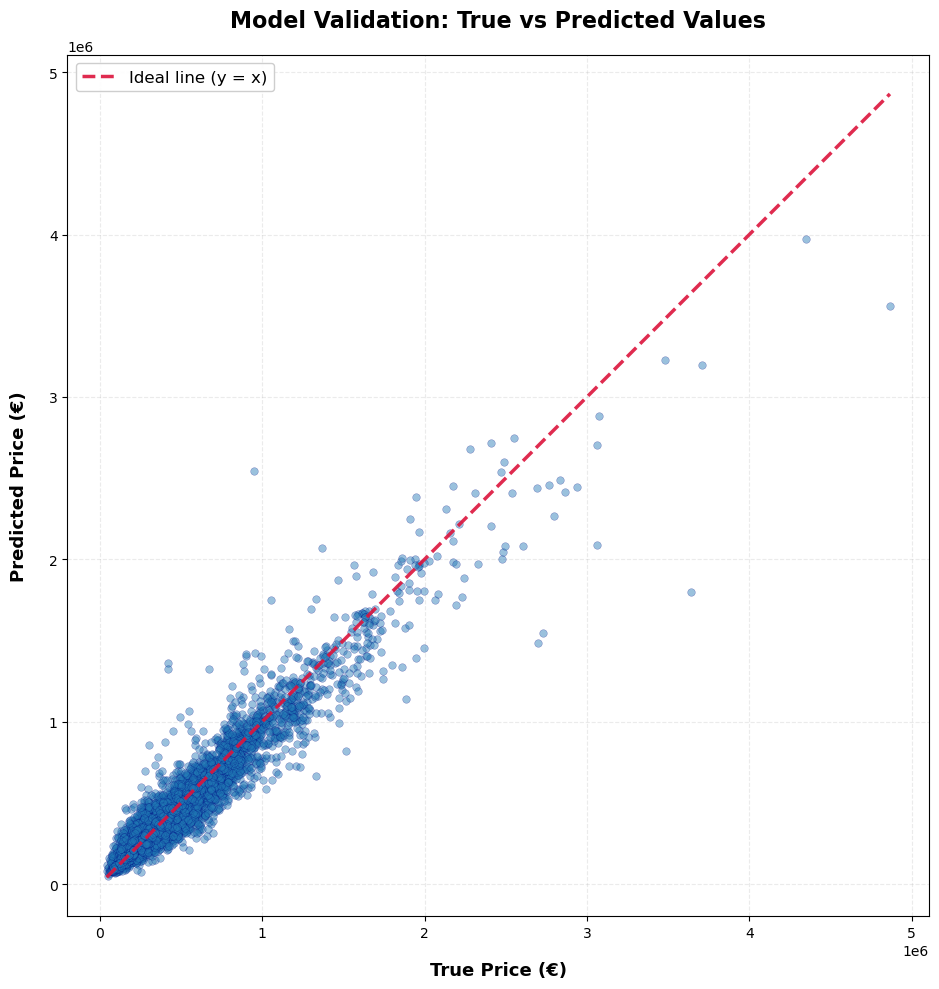

In [161]:
final_name = "RandomForest (5 vars) + log(y)"
y_test = cache[final_name]["y_test"]
y_pred = cache[final_name]["y_pred"]

# y_true vs y_pred (display only; no file output)
save_ytrue_vs_ypred(
    y_true=y_test,
    y_pred=y_pred,
    out_path=None,
    save=False,
    show=True,
    close=False,
)


### 8.2) Residuals distribution (log space)

Because the final model is trained on **log(y)**, we inspect residuals in **log1p space**:

- Centered around **0** → no strong overall bias.
- Rough symmetry → errors are balanced (over vs under).
- Heavy tails → a subset of listings is much harder (outliers, atypical properties, noisy features).

Interpreting log residuals: as a rough rule, a residual of **±0.10** corresponds to about **±10%** multiplicative error (especially for typical price ranges).


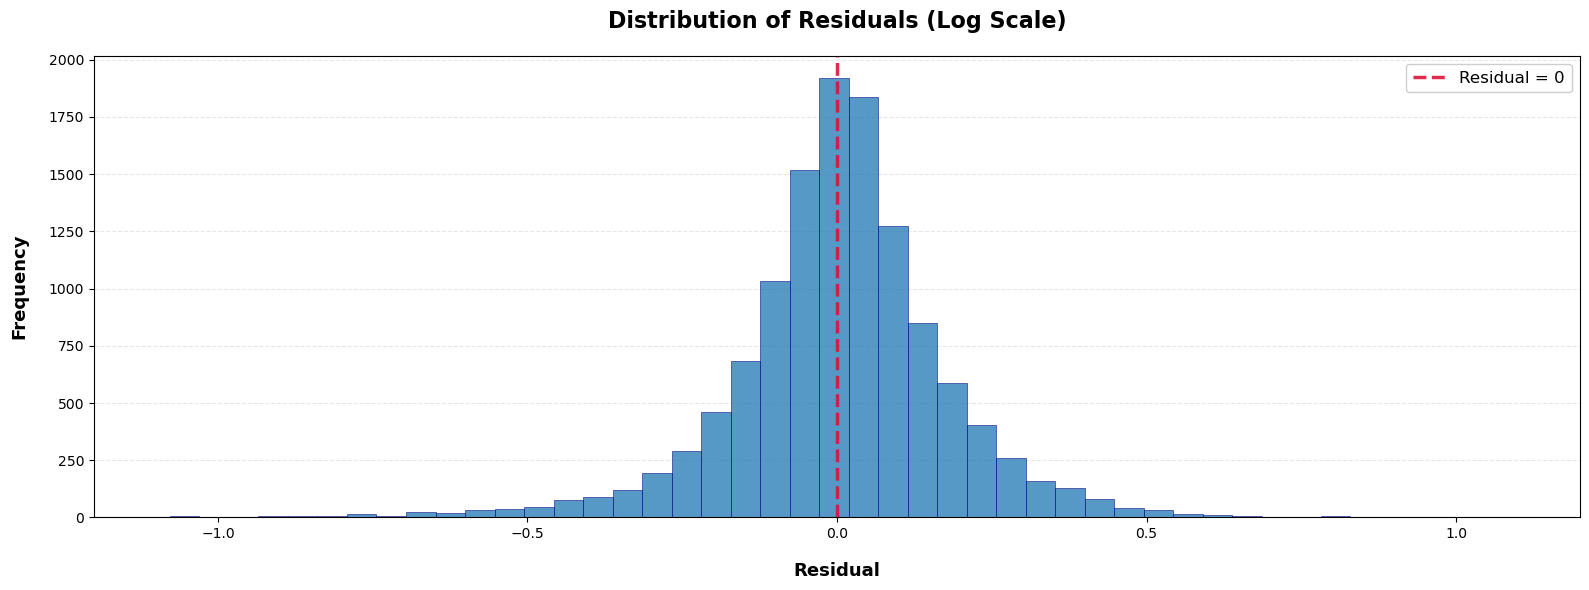

In [162]:
# Residual distribution in log1p space (display only; no file output)
save_residuals_hist_log(
    y_true=y_test,
    y_pred=y_pred,
    out_path=None,
    save=False,
    show=True,
    close=False,
    bins=50,
    xlim=(-1.2, 1.2),
)


### 8.3) Error analysis by price band (Holdout)

Aggregate metrics can hide where the model succeeds or fails.  
To make this explicit, we split the **holdout target** into **4 quantile-based price bands** and compute per-band:

- **RMSE / MAE (€):** typical error magnitude in euros  
- **Bias (pred−true):** direction of systematic error  
- **P90 abs err:** “tail risk” (how bad errors get for the worst 10%)  
- **R² (within band):** note that within narrow bands variance is small, so band-level R² can be unstable (often negative).  
  For this diagnostic we focus mainly on RMSE/MAE and Bias.


,band_label,Count,RMSE,MAE,Bias (pred-true),P90 abs err,R2
0,Q1 (€42k–€233k),3053,42988.0,28164.0,16130.0,62012.0,-0.175
1,Q2 (€234k–€327k),3092,48487.0,33112.0,4875.0,73322.0,-2.210
2,Q3 (€328k–€467k),3068,62090.0,41160.0,-7856.0,91575.0,-1.637
3,Q4 (€468k–€4.9M),3085,138977.0,88710.0,-42945.0,198169.0,0.859


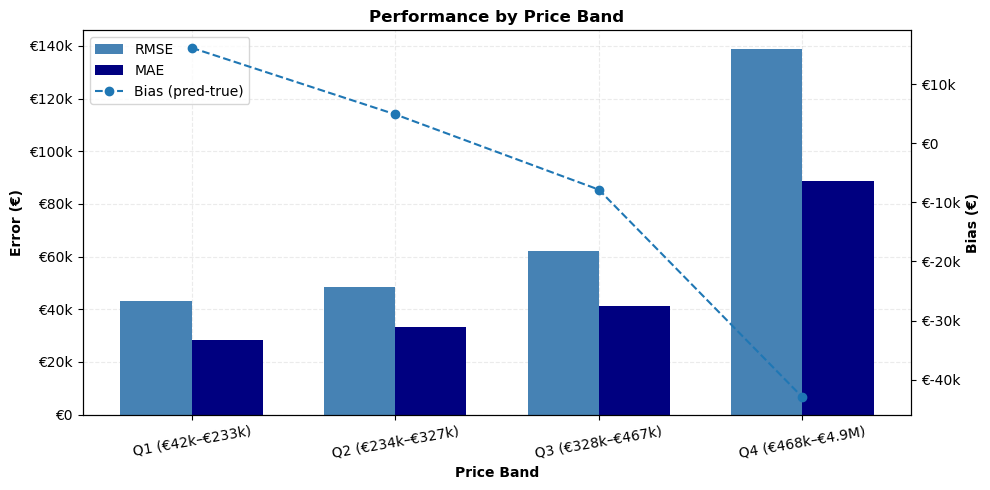

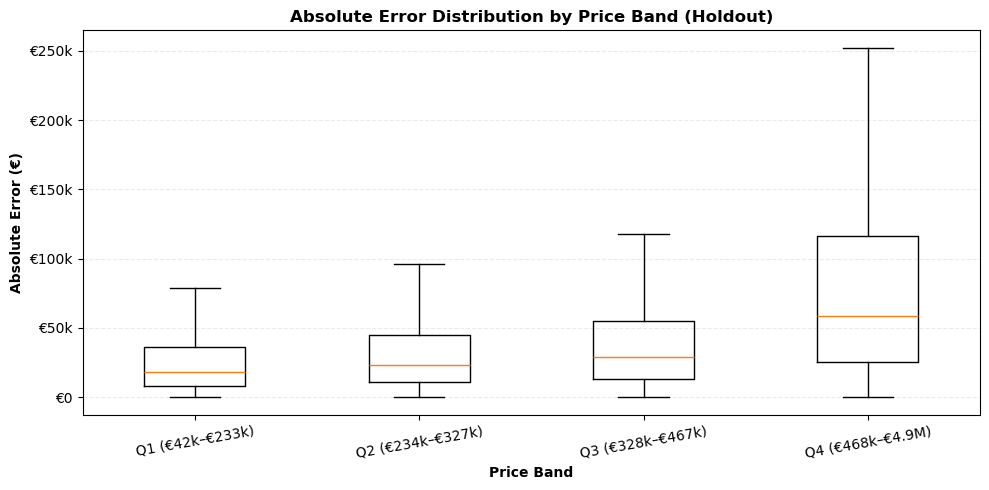

📌 Best-performing band (lowest RMSE): Q1 (€42k–€233k)
⚠️ Worst-performing band (highest RMSE): Q4 (€468k–€4.9M)


In [163]:
df_banded, summary_df = price_band_error_analysis(y_test, y_pred, q=4)

display(
    summary_df.assign(
        RMSE=summary_df["RMSE"].round(0),
        MAE=summary_df["MAE"].round(0),
        **{
            "Bias (pred-true)": summary_df["Bias (pred-true)"].round(0),
            "P90 abs err": summary_df["P90 abs err"].round(0),
            "R2": summary_df["R2"].round(3),
        }
    )
)

plot_band_summary(summary_df)
plot_abs_error_boxplot(df_banded)

best_band = summary_df.sort_values("RMSE").iloc[0]["band_label"]
worst_band = summary_df.sort_values("RMSE").iloc[-1]["band_label"]
print(f"📌 Best-performing band (lowest RMSE): {best_band}")
print(f"⚠️ Worst-performing band (highest RMSE): {worst_band}")


**Key takeaways from the band breakdown**

- **Error increases with price**, as expected: Q4 spans a much wider range (€468k–€4.9M), so absolute error naturally grows.
- The model shows a clear **underestimation trend in the high-end band**:  
  Q4 Bias ≈ **−€43k**, with RMSE ≈ **€139k** and P90 abs error ≈ **€198k**.
- Lower bands are closer to neutral/slight overestimation (e.g., Q1 Bias ≈ **+€16k**).

This diagnostic is extremely useful for product expectations: the model is reliable for *typical listings*, but high-end properties should be treated with extra caution (and ideally enhanced with richer features or calibration).


## 9) Conclusions

### The problem we tackled
The goal of this project was to estimate **Barcelona property prices** from historical listing data, focusing on a solution that is **reproducible, explainable, and robust**—prioritizing consistency and interpretability over extreme metric optimization.

---

### Why RF(5+log)? A principled trade-off
After testing 5 candidate models with rigorous cross-validation, we selected **Random Forest with 5 features + log transform** as the final model.

**The decision is grounded in:**
1. **Robustness:** 5-fold CV shows strong generalization and stable performance across folds  
2. **Simplicity:** 50% fewer features makes the model easier to explain, maintain, and deploy  
3. **Feature concentration:** the top-5 variables capture ~95% of the predictive power (from RF10 importance)  
4. **Acceptable trade-off:** a small RMSE increase compared to the best-performing alternative for a much simpler dependency set  

**This is not the best model by raw RMSE — but it's the best model for a clean, maintainable implementation.**

---

### What the final diagnostics tell us
- **Calibration (y_true vs y_pred):** dispersion widens at higher prices (heteroscedasticity), which is common in real-estate.
- **Residuals (log space):** residuals are centered near 0 overall; heavy tails typically correspond to outliers or rare listing profiles.
- **Price bands:** performance degrades in the high-end segment, revealing a tendency to **underestimate luxury properties** when data is scarce and features are limited (renovation quality, views, micro-location, etc.).

---

### What I learned (beyond the model)
The main takeaway was not simply selecting a model, but understanding how the **dataset structure**, **feature limitations**, and small **preprocessing/evaluation choices** can strongly affect stability and generalization. This project reinforced that strong results come from the full pipeline: EDA, validation, and decision-making—not only from chasing a slightly better metric.

---

### What this model means — and what it doesn’t
This model should not be interpreted as a single “correct” price. Instead, it provides a **statistical reference** based on historical data. Its strongest value is to support decision-making by offering a consistent baseline and helping detect meaningful deviations relative to typical market behavior—while acknowledging higher uncertainty for high-end listings.

---

### Next steps
1. Add richer signals for luxury homes (micro-location, amenities quality, renovation, view, building category).
2. Try **re-weighting** or a **two-stage approach** (separate model for Q4) to reduce high-end underestimation.
3. Add a simple **calibration layer** (e.g., linear correction per segment) and re-check bias.
4. Keep **error analysis by price band** as a monitoring-style view to track where the model is reliable vs where uncertainty grows.
